In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

### 2.1 On a series of E-mini S&P 500 futures tick data:
(a) Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.

In [90]:
# Download data from Yahoo Finance


def get_yf_data(ticker, start_date:pd.Timestamp, end_date:pd.Timestamp, interval='1m'):
    current_start=start_date
    while current_start < end_date:
        current_end = pd.to_datetime(current_start) + pd.Timedelta('7 days')
        if current_end > end_date:
            current_end = end_date
        data = yf.download(ticker, start=current_start, end=current_end, interval=interval, multi_level_index=False)
        if current_start == start_date:
            df = data
        else:
            df = pd.concat([df, data])
        current_start = current_end + pd.Timedelta('1 day')
    return df
cur_date = pd.Timestamp.now()
start_date = cur_date - pd.Timedelta('30 days')
df=get_yf_data('ES=F', start_date, cur_date, '1m')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [91]:

def get_volume_bars(df:pd.DataFrame, threshold:float):
    volume=df['Volume']
    volume_sum=0
    start_idx=0
    bar_list=[]
    for i in range(len(volume)):
        volume_sum+=volume.iloc[i]
        if volume_sum>=threshold:
            bar={
                'Open':df.iloc[start_idx]['Open'],
                'High':df.iloc[start_idx:i+1]['High'].max(),
                'Close':df.iloc[i]['Close'],
                'Low':df.iloc[start_idx:i+1]['Low'].min(),
                'Volume':df.iloc[start_idx:i+1]['Volume'].sum()
            }
            bar_list.append((df.index[i], bar))
            start_idx=i+1
            volume_sum=0
    dollar_bar=pd.DataFrame.from_dict(dict(bar_list), orient='index')
    return dollar_bar                


In [92]:
def get_dollar_bars(df:pd.DataFrame, threshold:float):
    dollar=df['Close']*df['Volume']
    dollar_sum=0
    start_idx=0
    bar_list=[]
    for i in range(len(dollar)):
        dollar_sum+=dollar.iloc[i]
        if dollar_sum>=threshold:
            bar={
                'Open':df.iloc[start_idx]['Open'],
                'High':df.iloc[start_idx:i+1]['High'].max(),
                'Close':df.iloc[i]['Close'],
                'Low':df.iloc[start_idx:i+1]['Low'].min(),
                'Volume':df.iloc[start_idx:i+1]['Volume'].sum()
            }
            bar_list.append((df.index[i], bar))
            start_idx=i+1
            dollar_sum=0
    dollar_bar=pd.DataFrame.from_dict(dict(bar_list), orient='index')
    return dollar_bar

(b) Count the number of bars produced by tick, volume, and dollar bars on a
weekly basis. Plot a time series of that bar count. What bar type produces
the most stable weekly count? Why?

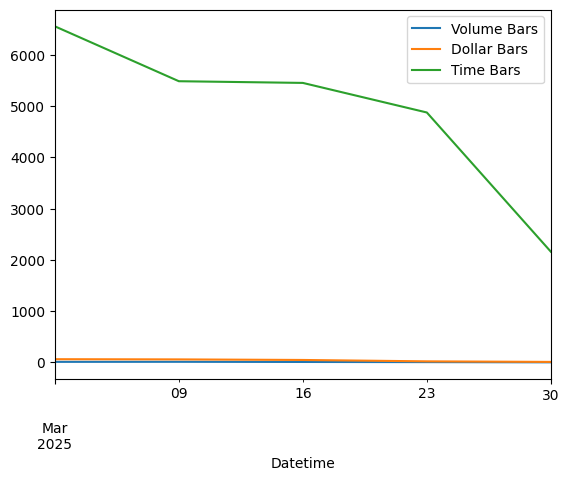

In [141]:
volume_bar=get_volume_bars(df, 1000000)
dollar_bar=get_dollar_bars(df, 1000000000)
volume_bar["Close"].resample('W').count().plot(label='Volume Bars')   
dollar_bar["Close"].resample('W').count().plot(label='Dollar Bars')
df["Close"].resample('W').count().plot(label='Time Bars')
plt.legend()
plt.show()

(c)  Compute the serial correlation of returns for the three bar types. What bar
method has the lowest serial correlation?

In [142]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

time_bar_return=df['Close'].pct_change().dropna()
volume_bar_return=volume_bar['Close'].pct_change().dropna()
dollar_bar_return=dollar_bar['Close'].pct_change().dropna()

ac_time=time_bar_return.autocorr(lag=1)
ac_volume=volume_bar_return.autocorr(lag=1)
ac_dollar=dollar_bar_return.autocorr(lag=1)
print('ac_time', ac_time, 'ac_volume', ac_volume, 'ac_dollar', ac_dollar)

ac_time 0.02229536271076704 ac_volume -0.09544063639216292 ac_dollar 0.010987186185353704


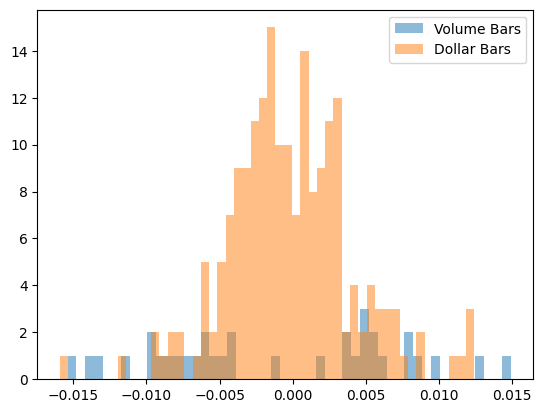

In [143]:

# histogram
#plt.hist(time_bar_return, bins=50, alpha=0.5, label='Time Bars')
plt.hist(volume_bar_return, bins=50, alpha=0.5, label='Volume Bars')
plt.hist(dollar_bar_return, bins=50, alpha=0.5, label='Dollar Bars')
plt.legend()
plt.show()

In [145]:
from scipy.stats import jarque_bera
jb_time=jarque_bera(time_bar_return)
jb_volume=jarque_bera(volume_bar_return)
jb_dollar=jarque_bera(dollar_bar_return)
print('jb_time', jb_time, 'jb_volume', jb_volume, 'jb_dollar', jb_dollar)

jb_time SignificanceResult(statistic=np.float64(132956060.04979818), pvalue=np.float64(0.0)) jb_volume SignificanceResult(statistic=np.float64(1.830675865877641), pvalue=np.float64(0.40038130119697485)) jb_dollar SignificanceResult(statistic=np.float64(13.07739403871364), pvalue=np.float64(0.001446371866303161))


2.2 On a series of E-mini S&P 500 futures tick data, compute dollar bars
and dollar imbalance bars. What bar type exhibits greater serial correlation?
Why?

In [146]:
def get_dollar_imbalance_bars(df:pd.DataFrame, alpha:float=0.9):
    b=df["Close"].diff().apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
    b=b.replace(0, np.nan).ffill().fillna(0)

    v=df['Close']*df["Volume"]
    theta=(b*v).cumsum()

    # EMA value
    ema_vt=v.iloc[:20].mean() # v^+ + v^-
    ema_theta=theta.iloc[:20].mean() # v^+ - v^-
    ema_t=20
    T=20

    bar_list=[]
    start_idx=20
    for i in range(20, len(df)):
        v_plus=(ema_vt+ema_theta)/2
        expected_imbalance=ema_t*(v_plus-ema_vt)
        T+=1

        if abs(theta.iloc[i])>=expected_imbalance:
            ema_vt=alpha*v.iloc[i]+(1-alpha)*ema_vt
            ema_theta=alpha*theta.iloc[i]+(1-alpha)*ema_theta
            ema_t=alpha*T+(1-alpha)*ema_t
            bar={
                'Open':df.iloc[start_idx]['Open'],
                'High':df.iloc[start_idx:i+1]['High'].max(),
                'Close':df.iloc[i]['Close'],
                'Low':df.iloc[start_idx:i+1]['Low'].min(),
                'Volume':df.iloc[start_idx:i+1]['Volume'].sum()
            }
            start_idx=i+1
            bar_list.append((df.index[i], bar))

    # create dollar imbalance bars
    dollar_bar=pd.DataFrame.from_dict(dict(bar_list), orient='index')
    return dollar_bar

dollar_imbalance_bar=get_dollar_imbalance_bars(df)
print(dollar_imbalance_bar["Close"].pct_change().dropna().autocorr(lag=1))
print(dollar_bar["Close"].pct_change().dropna().autocorr(lag=1))    

-0.25179160921466587
0.010987186185353704


2.4 Form E-mini S&P 500 futures dollar bars:

(a) Compute Bollinger bands of width 5% around a rolling moving average.
Count how many times prices cross the bands out (from within the bands
to outside the bands).

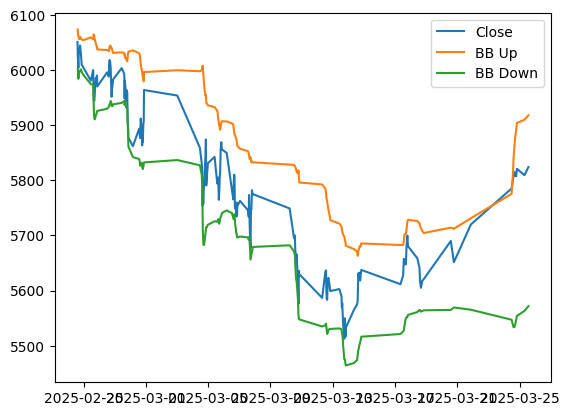

In [147]:
bb_up=dollar_bar["Close"].ewm(span=20).mean()+2*dollar_bar["Close"].ewm(span=20).std()
bb_down=dollar_bar["Close"].ewm(span=20).mean()-2*dollar_bar["Close"].ewm(span=20).std()
plt.plot(dollar_bar["Close"], label='Close')
plt.plot(bb_up, label='BB Up')
plt.plot(bb_down, label='BB Down')
plt.legend()
plt.show()

In [148]:
up_diff=(dollar_bar["Close"]-bb_up).dropna()
down_diff=(bb_down-dollar_bar["Close"]).dropna()
up_sign=np.sign(up_diff)
down_sign=np.sign(down_diff)
mask_up=((up_sign.shift(1)==-1) & (up_sign==1))
mask_down=((down_sign.shift(1)==-1) & (down_sign==1))
print('up_count', len(up_diff[mask_up]), 'down_count', len(down_diff[mask_down]))


up_count 1 down_count 1


(b) Now sample those bars using a CUSUM filter, where {yt} are returns and
h = 0.05. How many samples do you get?

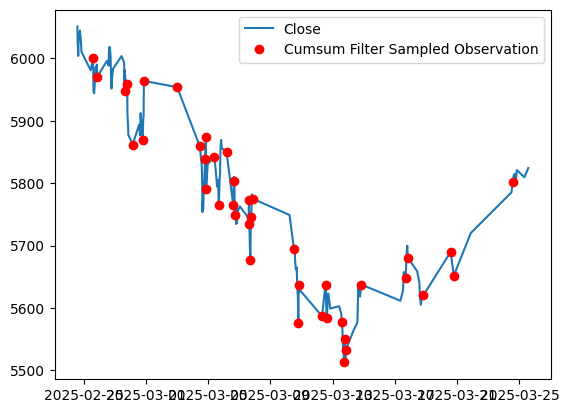

In [168]:
def get_cumsum_filter_data(df:pd.DataFrame, h=0.05):
    diff=df['Close'].pct_change().dropna().diff()
    s_pos, s_neg=0,0
    bar_list=[]
    start_idx=0
    for i in range(len(diff)):
        s_pos=max(0, s_pos+diff.iloc[i])
        s_neg=min(0, s_neg+diff.iloc[i])
        s=max(s_pos, -s_neg)
        if s>h:
            s_pos=0
            s_neg=0
            bar={
                'Open':df.iloc[start_idx]['Open'],
                'High':df.iloc[start_idx:i+1]['High'].max(),
                'Close':df.iloc[i]['Close'],
                'Low':df.iloc[start_idx:i+1]['Low'].min(),
                'Volume':df.iloc[start_idx:i+1]['Volume'].sum()
            }
            start_idx=i+1
            bar_list.append((df.index[i], bar))
    cumsum_bar=pd.DataFrame.from_dict(dict(bar_list), orient='index')
    return cumsum_bar

plt.plot(dollar_bar["Close"], label='Close')
plt.plot(get_cumsum_filter_data(dollar_bar, 0.01)["Close"], label='Cumsum Filter Sampled Observation', marker='o', color='r', linestyle='')
plt.legend()
plt.show()

2.5 Using the bars from exercise 4

(a) Sample bars using the CUSUM filter, where {yt} are absolute returns and
h = 0.05

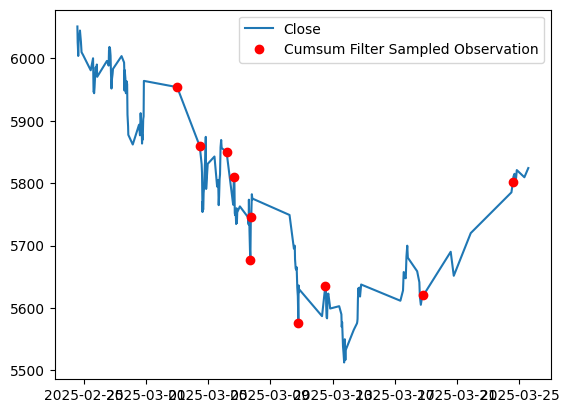

In [167]:
def get_abs_cumsum_filter_data(df:pd.DataFrame, h=0.05):
    diff=abs(df['Close'].pct_change().dropna()).diff()
    s_pos, s_neg=0,0
    bar_list=[]
    start_idx=0
    for i in range(len(diff)):
        s_pos=max(0, s_pos+diff.iloc[i])
        s_neg=min(0, s_neg+diff.iloc[i])
        s=max(s_pos, -s_neg)
        if s>h:
            s_pos=0
            s_neg=0
            bar={
                'Open':df.iloc[start_idx]['Open'],
                'High':df.iloc[start_idx:i+1]['High'].max(),
                'Close':df.iloc[i]['Close'],
                'Low':df.iloc[start_idx:i+1]['Low'].min(),
                'Volume':df.iloc[start_idx:i+1]['Volume'].sum()
            }
            start_idx=i+1
            bar_list.append((df.index[i], bar))
    cumsum_bar=pd.DataFrame.from_dict(dict(bar_list), orient='index')
    return cumsum_bar

plt.plot(dollar_bar["Close"], label='Close')
plt.plot(get_abs_cumsum_filter_data(dollar_bar, 0.01)["Close"], label='Cumsum Filter Sampled Observation', marker='o', color='r', linestyle='')
plt.legend()
plt.show()